# Results

In [1]:
import src.utils as utils
from src.solvers import pg_solver
from ray import tune

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import os

from tbparse import SummaryReader
import seaborn as sns; sns.set_theme()

2023-11-27 20:40:59.321350: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [27]:
def check_errors(exp_folder):
    """Check for errors in the hyperparameter searches."""
    # Find folders (for each n) inside exp_folder
    folders_n = sorted([os.path.join(exp_folder, folder) for folder in os.listdir(exp_folder)])

    errors = {}
    # Get path for every hyperparameter search
    for folder_n in folders_n:
        folder_clauses = sorted([os.path.join(folder_n, folder) for folder in os.listdir(folder_n)])
        folder_instances = sorted([os.path.join(folder, instance) for folder in folder_clauses for instance in os.listdir(folder)])
        folder_assumption = sorted([os.path.join(folder, assumption) for folder in folder_instances for assumption in os.listdir(folder)])

        # Get number of variables
        num_vars = folder_n.split('/')[-1]

        # Count errors for every hyperparameter search
        errors[f'n={num_vars}'] = {}
        errors[f'n={num_vars}']['num_errors'] = 0
        for i, search_path in enumerate(folder_assumption):
            
            # Restore the GridSearch object
            restored_tuner = tune.Tuner.restore(path=search_path,
                                                trainable=pg_solver,
                                                resume_unfinished=False,
                                                resume_errored=False,
                                                restart_errored=False)
            results = restored_tuner.get_results()
                    
            if results.num_errors > 0:
                #print(f'n={num_vars}, {search_path}, errors = {results.num_errors}, terminated = {results.num_terminated}')

                errors[f'n={num_vars}']['num_errors'] += 1
                errors[f'n={num_vars}'][f'{i}'] = f'path: {search_path}, errors: {results.errors}, num_errors: {results.num_errors},  terminated: {results.num_terminated}'

        errors[f'n={num_vars}']['num_searches'] = len(folder_assumption)
        #print(f'Total errors for n = {num_vars}: {errors}. Total searchs: {len(folder_assumption)}\n')

    # Print keys and values
    for key, value in errors.items():
        print(key)
        print(value)


def best_trials_csv(exp_folder, csv_path):
    """
    Generate dataframe with best trials from hyperparameter searches,
    and save it as a csv file in csv_path.
    """
    # Find folders (for each n) inside exp_folder
    folders_n = sorted([os.path.join(exp_folder, folder) for folder in os.listdir(exp_folder)])
    
    list_df = []
    for folder_n in folders_n:
        # Get path for every hyperparameter search
        folder_clauses = sorted([os.path.join(folder_n, folder) for folder in os.listdir(folder_n)])
        folder_instances = sorted([os.path.join(folder, instance) for folder in folder_clauses for instance in os.listdir(folder)])
        folder_assumption = sorted([os.path.join(folder, assumption) for folder in folder_instances for assumption in os.listdir(folder)])

        # Extract info from search_path
        for i, search_path in enumerate(folder_assumption):
            # Create experiment id
            split_path = search_path.split("/")
            n = split_path[2]
            m = split_path[3]
            i = split_path[4][-2:]
            s = split_path[5]
            exp_id = f'{n}/{m}/{i}/{s}'
            
            # Restore the GridSearch object
            restored_tuner = tune.Tuner.restore(path=search_path,
                                                trainable=pg_solver,
                                                resume_unfinished=False,
                                                resume_errored=False,
                                                restart_errored=False)
            results = restored_tuner.get_results()
            
            # Get dataframe with best trials. A best trial is a trial with the max value of num_sat_eval
            df_base = results.get_dataframe(filter_metric='num_sat_eval', filter_mode='max')

            # Keep only rows with the max value
            df_best = df_base[df_base['num_sat_eval'] == df_base['num_sat_eval'].max()]

            # keep only columns of interest
            #df_best = df_base[cols_keep]

            # Add n, m, i, s to df_best
            df_best.insert(0, 'exp', exp_id)
            df_best.insert(1, 'n', int(n))
            df_best.insert(2, 'm', int(m))
            df_best.insert(3, 'i', int(i))
            df_best.insert(4, 's', s)

            # Add r, and frac_sat to df_best
            df_best.insert(2, 'r', df_best['m'] / df_best['n'])
            df_best.insert(6, 'frac_sat', df_best['num_sat_eval'] / df_best['m'])

            list_df.append(df_best)

    # Concatenate the list of dataframes
    df = pd.concat(list_df, ignore_index=True)
    df.to_csv(csv_path, index=False)


def best_trials2best_feaures(df_best_trials, feature, normalize=True):
    """Given a dataframe with the best trials, return a dataframe with the fraction of time each value
    of the feature of interest happens for each n, r, s.
    """
    # Grouped by n, r, s count the number of times each feature of interest happens
    df_feature = df_best_trials.groupby(['n', 'r', 's', feature]).count().reset_index()
    df_feature = df_feature[['n', 'r', 's', feature, 'exp']]
    df_feature = df_feature.rename(columns={'exp': 'count'})

    # Unique values in column feature
    feature_vals = df_feature[feature].unique()

    # Unique values in column s
    searches = df_feature['s'].unique()

    # Generate dictionary with n, r, s as keys and feature_vals as values initialized to 0
    dic_ft = {}
    for n in df_feature['n'].unique():
        for r in df_feature['r'].unique():
            for s in searches:
                key = f'{n:04d}/{r}/{s}'
                dic_ft[key] = {'n': n, 'r': r, 's': s}
                for feature_val in feature_vals:
                    dic_ft[key][feature_val] = 0

    # Count the number of times each value of the feature of interest happens
    # Iterate over each row of df_feature
    for index, row in df_feature.iterrows():
        # Get values
        n, r, s, ft, count = row['n'], row['r'], row['s'], row[feature], row['count']
        # Update dictionary
        dic_ft[f'{n:04d}/{r}/{s}'][ft] = count

    # Create dataframe from dictionary
    df_ft = pd.DataFrame.from_dict(dic_ft, orient='index')

    # Normalize counts
    df_ft['num_best_trials'] = 0
    for feture_val in feature_vals:
        df_ft['num_best_trials'] += df_ft[feture_val]
    if normalize:    
        for feture_val in feature_vals:
            df_ft[feture_val] = df_ft[feture_val] / df_ft['num_best_trials']
    
    # Drop num_best_trials column
    df_ft = df_ft.drop(columns=['num_best_trials'])
    
    return df_ft

### Check for errors

In [4]:
# Check for errors in the hyperparameter searches
exp_folder = 'hypersearch/pg_solver'
check_errors(exp_folder)

n=0010
{'num_errors': 0, 'num_searches': 120}
n=0020
{'num_errors': 0, 'num_searches': 120}
n=0030
{'num_errors': 0, 'num_searches': 120}
n=0040
{'num_errors': 0, 'num_searches': 120}
n=0050
{'num_errors': 0, 'num_searches': 120}
n=0100
{'num_errors': 0, 'num_searches': 120}


### Build dataframe with best trials

In [4]:
# Generate dataframe with best trials and save it as a csv file
exp_folder = 'hypersearch/pg_solver'
csv_path = 'results/df_best_trials.csv'

# Build csv file
best_trials_csv(exp_folder, csv_path)

# Load df_best_trials from csv
df_best_trials = pd.read_csv(csv_path)
df_best_trials

exp    n    r    m  i         s  frac_sat    num_sat  \
0          0010/0010/01/arch   10  1.0   10  1      arch  1.000000    8.90625   
1          0010/0010/01/arch   10  1.0   10  1      arch  1.000000    8.81250   
2          0010/0010/01/arch   10  1.0   10  1      arch  1.000000    8.96875   
3          0010/0010/01/arch   10  1.0   10  1      arch  1.000000    9.03125   
4          0010/0010/01/arch   10  1.0   10  1      arch  1.000000    8.84375   
...                      ...  ...  ...  ... ..       ...       ...        ...   
11217      0100/0450/05/arch  100  4.5  450  5      arch  0.935556  392.56250   
11218      0100/0450/05/arch  100  4.5  450  5      arch  0.935556  394.78125   
11219      0100/0450/05/arch  100  4.5  450  5      arch  0.935556  393.90625   
11220  0100/0450/05/baseline  100  4.5  450  5  baseline  0.942222  394.15625   
11221  0100/0450/05/node2vec  100  4.5  450  5  node2vec  0.957778  428.21875   

               loss  num_sat_eval  ...  \
0        -61.995412          10.0  ...   
1        -61.068308          10.0  ...   
2        -62.555747          10.0  ...   
3        -62.650649          10.0  ...   
4        -60.038612          10.0  ...   
...             ...           ...  ...   
11217 -26996.405002         421.0  ...   
11218 -27266.661330         421.0  ...   
11219 -16900.780084         421.0  ...   
11220 -27319.798705         424.0  ...   
11221     -4.240577         431.0  ...   

                                          config/n2v_dir  config/n2v_lr  \
0                                                    NaN            NaN   
1                                                    NaN            NaN   
2                                                    NaN            NaN   
3                                                    NaN            NaN   
4                                                    NaN            NaN   
...                                                  ...            ...   
11217                                                NaN            NaN   
11218                                                NaN            NaN   
11219                                                NaN            NaN   
11220                                                NaN            NaN   
11221  /home/ogutierrez/Documents/Code/Learning-SAT-S...       0.041317   

       config/n2v_num_epochs  config/n2v_p  config/n2v_pretrained  \
0                        NaN           NaN                    NaN   
1                        NaN           NaN                    NaN   
2                        NaN           NaN                    NaN   
3                        NaN           NaN                    NaN   
4                        NaN           NaN                    NaN   
...                      ...           ...                    ...   
11217                    NaN           NaN                    NaN   
11218                    NaN           NaN                    NaN   
11219                    NaN           NaN                    NaN   
11220                    NaN           NaN                    NaN   
11221                   30.0           0.5                   True   

      config/n2v_q config/n2v_verbose  config/n2v_walk_len  \
0              NaN                NaN                  NaN   
1              NaN                NaN                  NaN   
2              NaN                NaN                  NaN   
3              NaN                NaN                  NaN   
4              NaN                NaN                  NaN   
...            ...                ...                  ...   
11217          NaN                NaN                  NaN   
11218          NaN                NaN                  NaN   
11219          NaN                NaN                  NaN   
11220          NaN                NaN                  NaN   
11221          4.0                0.0                 20.0   

       config/n2v_walks_per_node  config/n2v_workers  
0                

### Average fraction of satisfiable clauses as the radius r increased.
The average is over the five different instances and the six different values of n.

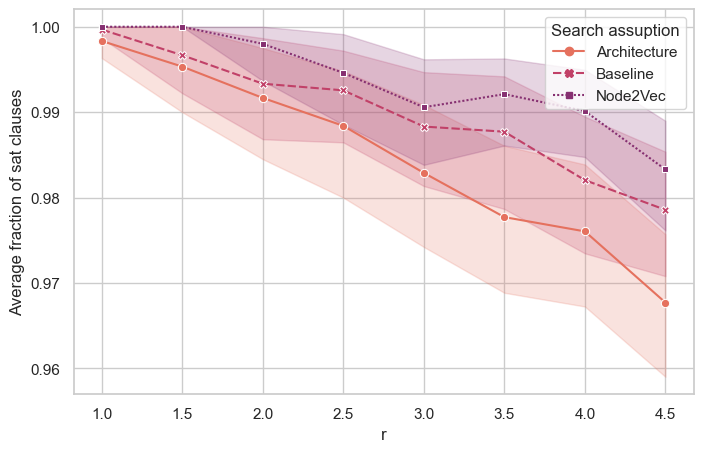

In [4]:
# Load df_best_trials from csv
csv_path = 'results/df_best_trials.csv'
df_best_trials = pd.read_csv(csv_path)

# Keep only exp, n, r, i, s, frac_sat
df_max_frac_sat = df_best_trials[['exp', 'n', 'r', 'i', 's', 'frac_sat']]

# Rename s to search
df_max_frac_sat = df_max_frac_sat.rename(columns={'s': 'search'})

# Drop duplicates, keeping the fraction of satisfiable clauses with the highest value for each experiment
df_max_frac_sat = df_max_frac_sat.drop_duplicates(subset=['exp'])

# In 'search' column replace 'arch' with 'Architercture', 'baseline' with 'Baseline', and 'node2vec' with 'Node2Vec'
df_max_frac_sat['search'] = df_max_frac_sat['search'].replace({'arch': 'Architecture', 'baseline': 'Baseline', 'node2vec': 'Node2Vec'})

# Generate figure
plt.figure(figsize=(8, 5))
sns.set_theme(style="whitegrid")

sns.lineplot(data=df_max_frac_sat, x="r", y="frac_sat", hue="search", style="search", errorbar=('ci', 99), markers=True, palette='flare', legend='auto')
plt.ylabel('Average fraction of sat clauses')
plt.legend(title='Search assuption', loc='upper right')

#plt.tight_layout()
#plt.show()
plot_path = 'results/frac_sat.png'
plt.savefig(plot_path, dpi=300, bbox_inches='tight', pad_inches=0.1)

### Average fraction of satisfiable clauses as the radius r increase for n=10, 20, 30, 40, 50, and 100.
The average is over the five different instances for each n, and plots are arranged from left to right and top to bottom.

<Figure size 640x480 with 0 Axes>

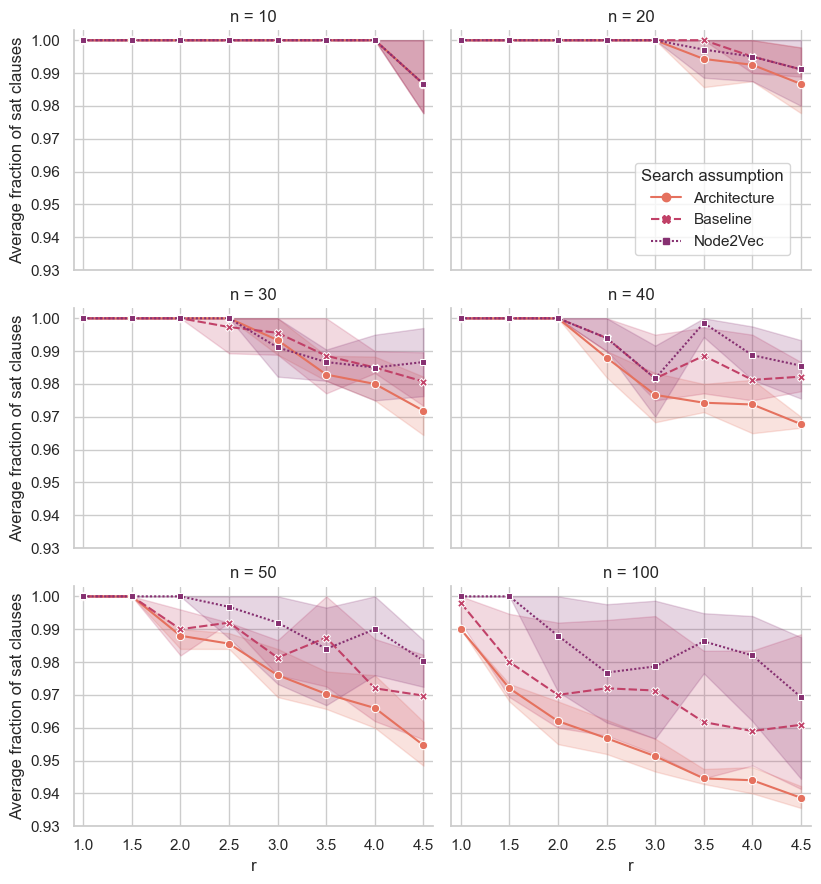

In [5]:
# Load df_best_trials from csv
csv_path = 'results/df_best_trials.csv'
df_best_trials = pd.read_csv(csv_path)

# Keep only exp, n, r, i, s, frac_sat
df_max_frac_sat = df_best_trials[['exp', 'n', 'r', 'i', 's', 'frac_sat']]

# Rename s to search
#df_max_frac_sat = df_max_frac_sat.rename(columns={'s': 'search'})

# Drop duplicates, keeping the fraction of satisfiable clauses with the highest value for each experiment
df_max_frac_sat = df_max_frac_sat.drop_duplicates(subset=['exp'])

# Generate figure
plt.figure()
sns.set_theme(style="whitegrid")
g = sns.relplot(data=df_max_frac_sat, x="r", y="frac_sat", hue="s", style="s", col="n", col_wrap=2,
                errorbar=('ci', 99), markers=True, palette='flare', kind='line',
                facet_kws=dict(sharex=True, sharey=True), height=3, aspect=1.4, legend='auto')

g.axes[0].set_ylim(0.93, 1.003)
g.axes[1].set_ylim(0.93, 1.003)
g.axes[2].set_ylim(0.93, 1.003)
g.axes[3].set_ylim(0.93, 1.003)
g.axes[4].set_ylim(0.93, 1.003)
g.axes[5].set_ylim(0.93, 1.003)

g.axes[0].set_yticks([0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.00])
g.axes[1].set_yticks([0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.00])
g.axes[2].set_yticks([0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.00])
g.axes[3].set_yticks([0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.00])
g.axes[4].set_yticks([0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.00])
g.axes[5].set_yticks([0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.00])
# g.axes[0].set_yticklabels([])  # Remove y tick labels

g.axes[0].set_xlim(0.9, 4.6)
g.axes[1].set_xlim(0.9, 4.6)
g.axes[2].set_xlim(0.9, 4.6)
g.axes[3].set_xlim(0.9, 4.6)
g.axes[4].set_xlim(0.9, 4.6)
g.axes[5].set_xlim(0.9, 4.6)

g.axes[0].set_xticks([1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5])
g.axes[1].set_xticks([1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5])
g.axes[2].set_xticks([1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5])
g.axes[3].set_xticks([1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5])
g.axes[4].set_xticks([1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5])
g.axes[5].set_xticks([1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5])

g.axes[0].set_ylabel('Average fraction of sat clauses')
g.axes[1].set_ylabel('')
g.axes[2].set_ylabel('Average fraction of sat clauses')
g.axes[3].set_ylabel('')
g.axes[4].set_ylabel('Average fraction of sat clauses')
g.axes[5].set_ylabel('')

# Configure legend
leg = g._legend
leg.set_bbox_to_anchor([0.83, 0.75])
new_labels = ['Architecture', 'Baseline', 'Node2Vec']
for t, l in zip(leg.texts, new_labels): t.set_text(l)
leg.set_title('Search assumption')
leg.set_frame_on(True)

#plt.tight_layout()
#plt.show()
plot_path = 'results/frac_sat_by_n.png'
plt.savefig(plot_path, dpi=300, bbox_inches='tight', pad_inches=0.1)

### Average number of best trials
The average is over the five different instances and the three different search assumptions.

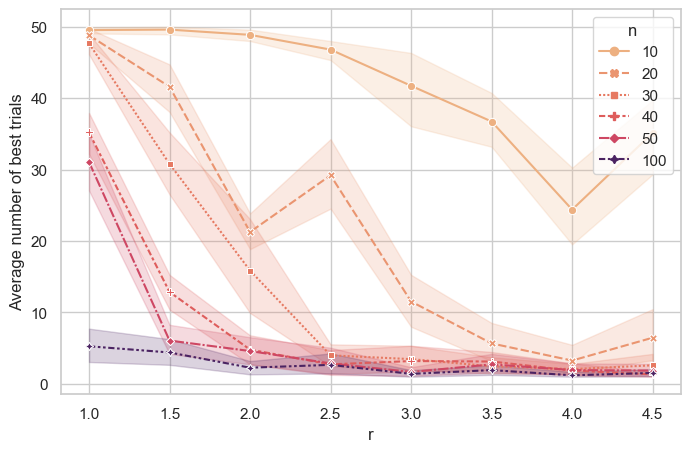

In [6]:
# Load df_best_trials from csv
csv_path = 'results/df_best_trials.csv'
df_best_trials = pd.read_csv(csv_path)

# Group by n, r, s, i, count number of times each combination appears (num best trials)
df_num_bt = df_best_trials.groupby(['n', 'r', 's', 'i']).size().reset_index(name='num_best_trials')

# Generate figure
plt.figure(figsize=(8, 5))
sns.set_theme(style="whitegrid")
sns.lineplot(data=df_num_bt, x="r", y="num_best_trials", hue="n", style="n", errorbar=('ci', 99), markers=True, palette='flare', legend='auto')
plt.ylabel('Average number of best trials')
plt.legend(title='n', loc='upper right')

#plt.tight_layout()
#plt.show()
plot_path = 'results/num_best_trials.png'
plt.savefig(plot_path, dpi=300, bbox_inches='tight', pad_inches=0.1)

### Fraction of times a Transformer decoder is present in the best trials

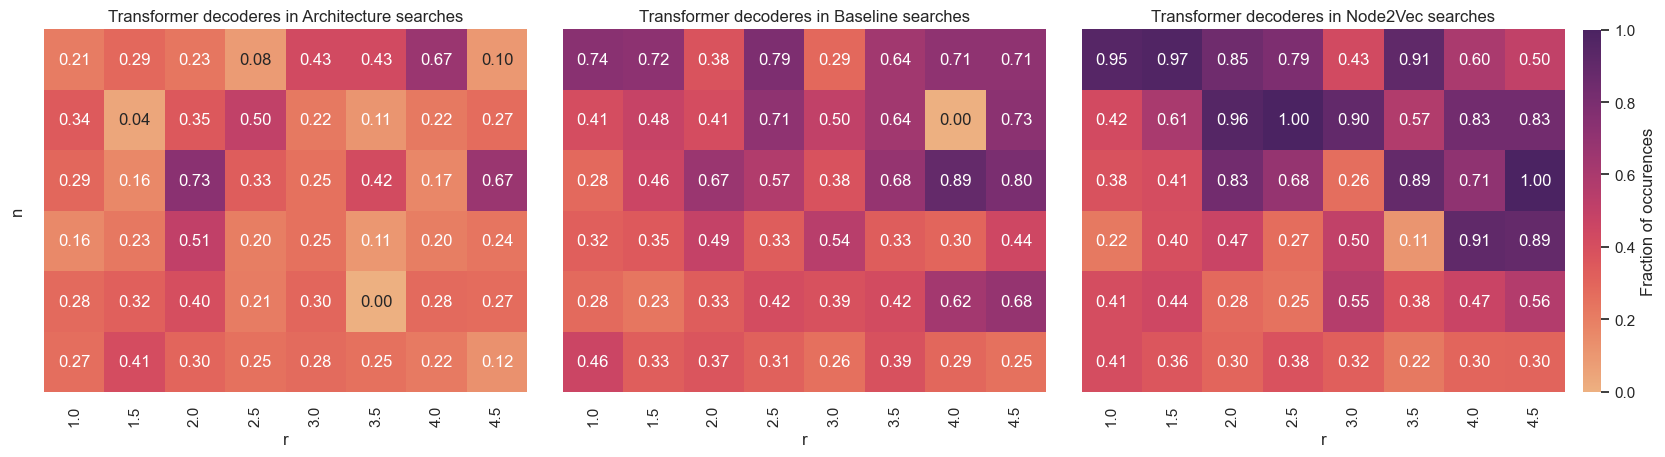

In [7]:
# Generate dataframe with fraction of times each value of the feature of interest happens
csv_path = 'results/df_best_trials.csv'
feature = 'config/decoder'
df_best_trials = pd.read_csv(csv_path)
df_ft = best_trials2best_feaures(df_best_trials, feature)

# Drop some column to keep only Transformer
df_ft = df_ft.drop(columns=['GRU', 'LSTM'])

# Generate list of dataframes
list_df = []
for s in ['arch', 'baseline', 'node2vec']:
    # Get df for each search assumption
    # Keep only rows with specific s
    df_s = df_ft[df_ft['s'] == s]
    # Convert column r to row
    df_s = df_s.pivot(index='n', columns='r', values=['Transformer'])
    # Order from largest to smallest n
    df_s = df_s.reindex(index=df_s.index[::-1])
    list_df.append(df_s)


# Generate plot
fig, axes = plt.subplots(1, 3, sharex=False, sharey=True, figsize=(21, 5))
sns.set_theme(style="whitegrid")

# Subplot 1: Architecture Search
inst = 0
sns.heatmap(list_df[0], annot=True, vmin=0, vmax=1, cmap='flare', cbar=True, fmt=".2f", square=True, ax=axes[inst],
            cbar_kws={'label': 'Fraction of occurences', 'pad': 0.03, "shrink": 0.94})
axes[inst].set_xticklabels([1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5])
axes[inst].set_xlabel('r')
axes[inst].set_title('Transformer decoderes in Architecture searches')
axes[inst].collections[0].colorbar.ax.set_visible(False)

# Subplot 2: Baseline Search
inst = 1
sns.heatmap(list_df[1], annot=True, vmin=0, vmax=1, cmap='flare', cbar=True, fmt=".2f", square=True, ax=axes[inst],
            cbar_kws={'label': 'Fraction of occurences', 'pad': 0.03, "shrink": 0.94})
axes[inst].set_xticklabels([1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5])
axes[inst].set_xlabel('r')
axes[inst].set_yticklabels([])
axes[inst].set_ylabel('')
axes[inst].set_title('Transformer decoderes in Baseline searches')
axes[inst].collections[0].colorbar.ax.set_visible(False)

# Subplot 3: Node2Vec Search
inst = 2
sns.heatmap(list_df[2], annot=True, vmin=0, vmax=1, cmap='flare', cbar=True, fmt=".2f", square=True, ax=axes[inst],
            cbar_kws={'label': 'Fraction of occurences', 'pad': 0.03, "shrink": 0.94})
axes[inst].set_xticklabels([1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5])
axes[inst].set_xlabel('r')
axes[inst].set_yticklabels([])
axes[inst].set_ylabel('')
axes[inst].set_title('Transformer decoderes in Node2Vec searches')
axes[inst].collections[0].colorbar.ax.set_visible(True)

#plt.tight_layout()
plt.subplots_adjust(wspace=-.12, hspace=0)
#plt.show()

plot_path = 'results/transformer.png'
plt.savefig(plot_path, dpi=300, bbox_inches='tight', pad_inches=0.1)

### Fraction of times a non-zero baseline is present in the best trials

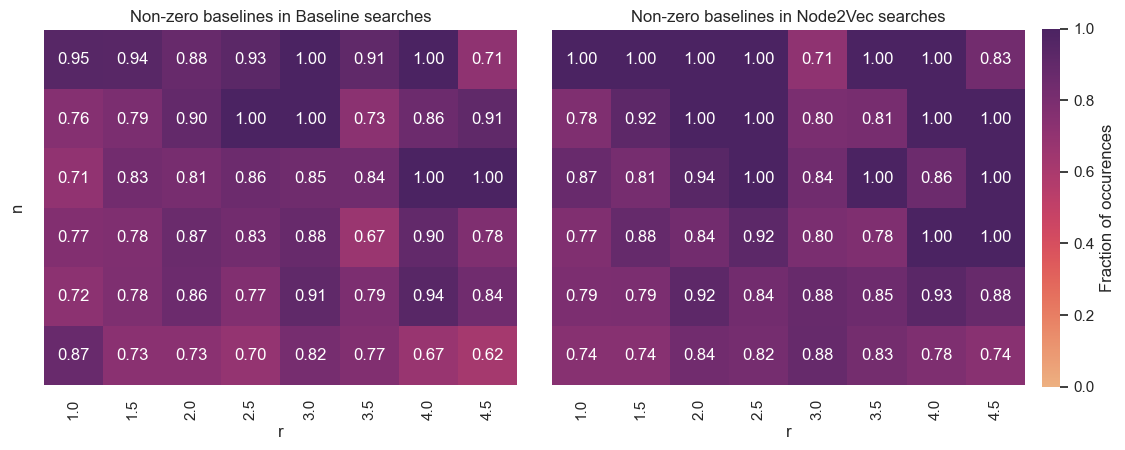

In [8]:
# Generate dataframe with fraction of times each value of the feature of interest happens
csv_path = 'results/df_best_trials.csv'
feature = 'config/baseline'
df_best_trials = pd.read_csv(csv_path)
df_ft = best_trials2best_feaures(df_best_trials, feature)

# Keep only rows with baseline or node2vec search assumption
df_ft = df_ft[df_ft['s'] != 'arch']

# Sum ema, greedy, sample baselines
df_ft['baseline'] =  df_ft['ema'] + df_ft['greedy'] + df_ft['sample']

# Drop irrelevant columns
df_ft = df_ft.drop(columns=['zero', 'ema', 'greedy', 'sample'])

# Convert column r to row (for baseline search)
df_b = df_ft[df_ft['s'] == 'baseline'].pivot(index='n', columns='r', values=['baseline'])
# Order from largest to smallest n
df_b = df_b.reindex(index=df_b.index[::-1])

# Convert column r to row (for node2vec search)
df_n = df_ft[df_ft['s'] == 'node2vec'].pivot(index='n', columns='r', values=['baseline'])
# Order from largest to smallest n
df_n = df_n.reindex(index=df_n.index[::-1])


# Generate plot
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(1, 2, sharex=False, sharey=True, figsize=(14, 5))

# Subplot 1: Baseline Search
inst = 0
sns.heatmap(df_b, annot=True, vmin=0, vmax=1, cmap='flare', cbar=True, fmt=".2f", square=True, ax=axes[inst],
            cbar_kws={'label': 'Fraction of occurences', 'pad': 0.03, "shrink": 0.94})
axes[inst].set_xticklabels([1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5])
axes[inst].set_xlabel('r')
axes[inst].set_title('Non-zero baselines in Baseline searches')
axes[inst].collections[0].colorbar.ax.set_visible(False)


# Subplot 2: Node2Vec Search
inst = 1
sns.heatmap(df_n, annot=True, vmin=0, vmax=1, cmap='flare', cbar=True, fmt=".2f", square=True, ax=axes[inst],
            cbar_kws={'label': 'Fraction of occurences', 'pad': 0.03, "shrink": 0.93})
axes[inst].set_xticklabels([1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5])
axes[inst].set_xlabel('r')
axes[inst].set_yticklabels([])
axes[inst].set_ylabel('')
axes[inst].set_title('Non-zero baselines in Node2Vec searches')
axes[inst].collections[0].colorbar.ax.set_visible(True)

#plt.tight_layout()
plt.subplots_adjust(wspace=-.12, hspace=0)
#plt.show()

plot_path = 'results/baseline.png'
plt.savefig(plot_path, dpi=300, bbox_inches='tight', pad_inches=0.1)

### Average fraction of times the different baselines are present in the best trials

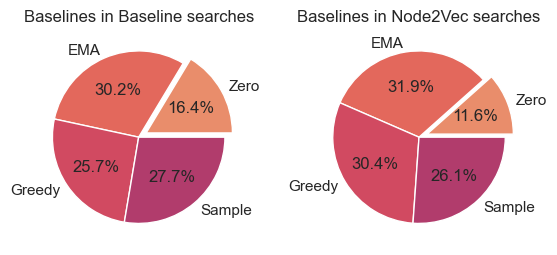

In [9]:
# Generate dataframe with fraction of times each value of the feature of interest happens
csv_path = 'results/df_best_trials.csv'
feature = 'config/baseline'
df_best_trials = pd.read_csv(csv_path)
df_ft = best_trials2best_feaures(df_best_trials, feature)

# Eliminate rows with s==arch
df_ft = df_ft[df_ft['s'] != 'arch']

# Keep rows with s=baseline an columns zero, ema, greedy and sample
df_b = df_ft[df_ft['s'] == 'baseline']
df_b = df_b[['zero', 'ema', 'greedy', 'sample']]
# Get mean of each column
mean_b = df_b.mean(axis=0)

# Keep rows with s=node2vec an columns zero, ema, greedy and sample
df_n = df_ft[df_ft['s'] == 'node2vec']
df_n = df_n[['zero', 'ema', 'greedy', 'sample']]
# Get mean of each column
mean_n = df_n.mean(axis=0)


# Generate plot
fig, axes = plt.subplots(1, 2, sharex=False, sharey=False)
sns.set_theme(style="whitegrid")

# Labels for data
labels = ['Zero', 'EMA', 'Greedy', 'Sample']
# Declaring exploding pie
explode = [0.1, 0, 0, 0]
# Define Seaborn color palette to use
palette_color = sns.color_palette('flare')

# Subfigure 1: Baseline Search
axes[0].pie(mean_b, labels=labels, colors=palette_color, explode=explode, autopct='%.1f%%')
axes[0].set_title('Baselines in Baseline searches')

# Subfigure 2: Node2Vec Search
axes[1].pie(mean_n, labels=labels, colors=palette_color, explode=explode, autopct='%.1f%%')
axes[1].set_title('Baselines in Node2Vec searches')


plt.subplots_adjust(wspace=0.3, hspace=0)
#plt.tight_layout()
#plt.show()

plot_path = 'results/baseline_pie.png'
plt.savefig(plot_path, dpi=300, bbox_inches='tight', pad_inches=0.1)

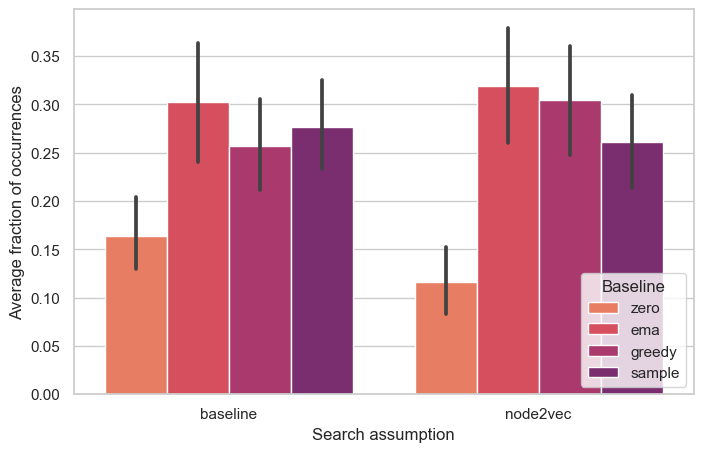

In [24]:
# Generate dataframe with fraction of times each value of the feature of interest happens
csv_path = 'results/df_best_trials.csv'
feature = 'config/baseline'
df_best_trials = pd.read_csv(csv_path)
df_ft = best_trials2best_feaures(df_best_trials, feature)

# Eliminate rows with s=arch
df_ft = df_ft[df_ft['s'] != 'arch']

# Convert zero emma greedy and sample columns into rows
df_ft = df_ft.melt(id_vars=['n', 'r', 's'],
                   value_vars=['zero', 'ema', 'greedy', 'sample'],
                   var_name='baseline',
                   value_name='fraction')


# Generate plot
plt.figure(figsize = (8,5))
sns.set_theme(style="whitegrid")

sns.barplot(x = "s", 
            y = "fraction", 
            data = df_ft,
            errorbar=('ci', 99),
            palette = "flare",
            saturation = 1,
            hue='baseline')

plt.ylabel('Average fraction of occurrences')
plt.xlabel('Search assumption')
plt.legend(title='Baseline', loc='lower right')
#plt.tight_layout()
#plt.show()

plot_path = 'results/baseline_bars.png'
plt.savefig(plot_path, dpi=300, bbox_inches='tight', pad_inches=0.1)

### Fraction of times a Node2Vec embedding is present in the best trials

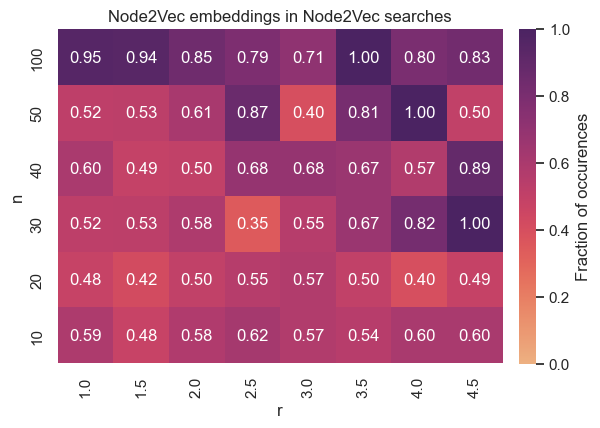

In [10]:
# Generate dataframe with fraction of times each value of the feature of interest happens
csv_path = 'results/df_best_trials.csv'
feature = 'config/dec_var_initializer'
df_best_trials = pd.read_csv(csv_path)
df_ft = best_trials2best_feaures(df_best_trials, feature)

# Keep only rows with s=node2vec
df_ft = df_ft[df_ft['s'] == 'node2vec']

# Drop irrelevant columns
df_ft = df_ft.drop(columns=['BasicVar'])

# Convert column r to row (for baseline search)
df_ft = df_ft.pivot(index='n', columns='r', values=['Node2VecVar'])
# Order from largest to smallest n
df_ft = df_ft.reindex(index=df_ft.index[::-1])


# Generate plot
fig, ax = plt.subplots(1, 1, sharex=False, sharey=True, figsize=(7, 5))
sns.set_theme(style="whitegrid")

# Subplot 1: Node2Vec Search
sns.heatmap(df_ft, annot=True, vmin=0, vmax=1, cmap='flare', cbar=True, fmt=".2f", square=True, ax=ax,
            cbar_kws={'label': 'Fraction of occurences', 'pad': 0.03, "shrink": 0.87})
ax.set_xticklabels([1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5])
ax.set_xlabel('r')
ax.set_title('Node2Vec embeddings in Node2Vec searches')
#axes[inst].collections[0].colorbar.ax.set_visible(False)


#plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
#plt.show()

plot_path = 'results/node2vec.png'
plt.savefig(plot_path, dpi=300, bbox_inches='tight', pad_inches=0.1)

### Fraction of times the context is present in the best trials

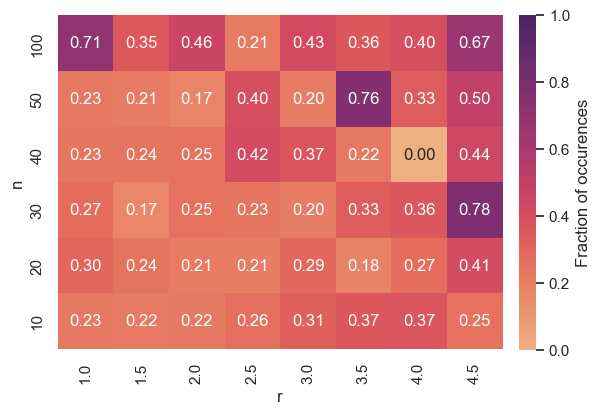

In [41]:
# Generate dataframe with fraction of times each value of the feature of interest happens
csv_path = 'results/df_best_trials.csv'
feature = 'config/dec_context_initializer'
df_best_trials = pd.read_csv(csv_path)
df_ft = best_trials2best_feaures(df_best_trials, feature)

# Keep only rows with s=node2vec
df_ft = df_ft[df_ft['s'] == 'node2vec']

# Drop irrelevant columns
df_ft = df_ft.drop(columns=['EmptyContext'])

# Convert column r to row
df_ft = df_ft.pivot(index='n', columns='r', values=['Node2VecContext'])
# Order from largest to smallest n
df_ft = df_ft.reindex(index=df_ft.index[::-1])


# Generate plot
fig, ax = plt.subplots(1, 1, sharex=False, sharey=True, figsize=(7, 5))
sns.set_theme(style="whitegrid")

# Subplot 1: Node2Vec Search
sns.heatmap(df_ft, annot=True, vmin=0, vmax=1, cmap='flare', cbar=True, fmt=".2f", square=True, ax=ax,
            cbar_kws={'label': 'Fraction of occurences', 'pad': 0.03, "shrink": 0.87})
ax.set_xticklabels([1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5])
ax.set_xlabel('r')
#ax.set_title('Context in node2vec searches')
#axes[inst].collections[0].colorbar.ax.set_visible(False)


#plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
#plt.show()

plot_path = 'results/context.png'
plt.savefig(plot_path, dpi=300, bbox_inches='tight', pad_inches=0.1)

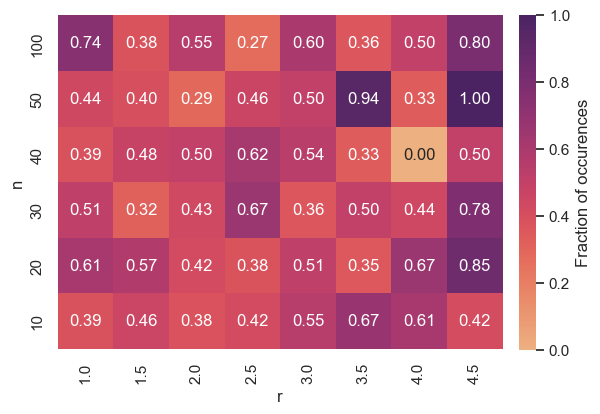

In [42]:
# Generate dataframe with fraction of times each value of the feature of interest happens
csv_path = 'results/df_best_trials.csv'
feature_emb = 'config/dec_var_initializer'
feature_con = 'config/dec_context_initializer'
df_best_trials = pd.read_csv(csv_path)

df_emb = best_trials2best_feaures(df_best_trials, feature_emb, normalize=False)
df_ft = best_trials2best_feaures(df_best_trials, feature_con, normalize=False)

# Keep only rows with s=node2vec
df_emb = df_emb[df_emb['s'] == 'node2vec']
df_ft = df_ft[df_ft['s'] == 'node2vec']

# Drop irrelevant columns
df_emb = df_emb.drop(columns=['BasicVar'])
df_ft = df_ft.drop(columns=['EmptyContext'])

# Normalize Node2VecContext by dividing by the number of Node2VecVar
df_ft['Node2VecContext'] = df_ft['Node2VecContext'] / df_emb['Node2VecVar']

# Convert column r to row
df_ft = df_ft.pivot(index='n', columns='r', values=['Node2VecContext'])
# Order from largest to smallest n
df_ft = df_ft.reindex(index=df_ft.index[::-1])


# Generate plot
fig, ax = plt.subplots(1, 1, sharex=False, sharey=True, figsize=(7, 5))
sns.set_theme(style="whitegrid")

# Subplot 1: Node2Vec Search
sns.heatmap(df_ft, annot=True, vmin=0, vmax=1, cmap='flare', cbar=True, fmt=".2f", square=True, ax=ax,
            cbar_kws={'label': 'Fraction of occurences', 'pad': 0.03, "shrink": 0.87})
ax.set_xticklabels([1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5])
ax.set_xlabel('r')
#ax.set_title('Contexts when Node2Vec embeddings are used')
#axes[inst].collections[0].colorbar.ax.set_visible(False)


#plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
#plt.show()

plot_path = 'results/context_norm.png'
plt.savefig(plot_path, dpi=300, bbox_inches='tight', pad_inches=0.1)

### Fraction of times Transformer decoders, non-zero baselines, and Node2Vec embeddings are present in the best trials.

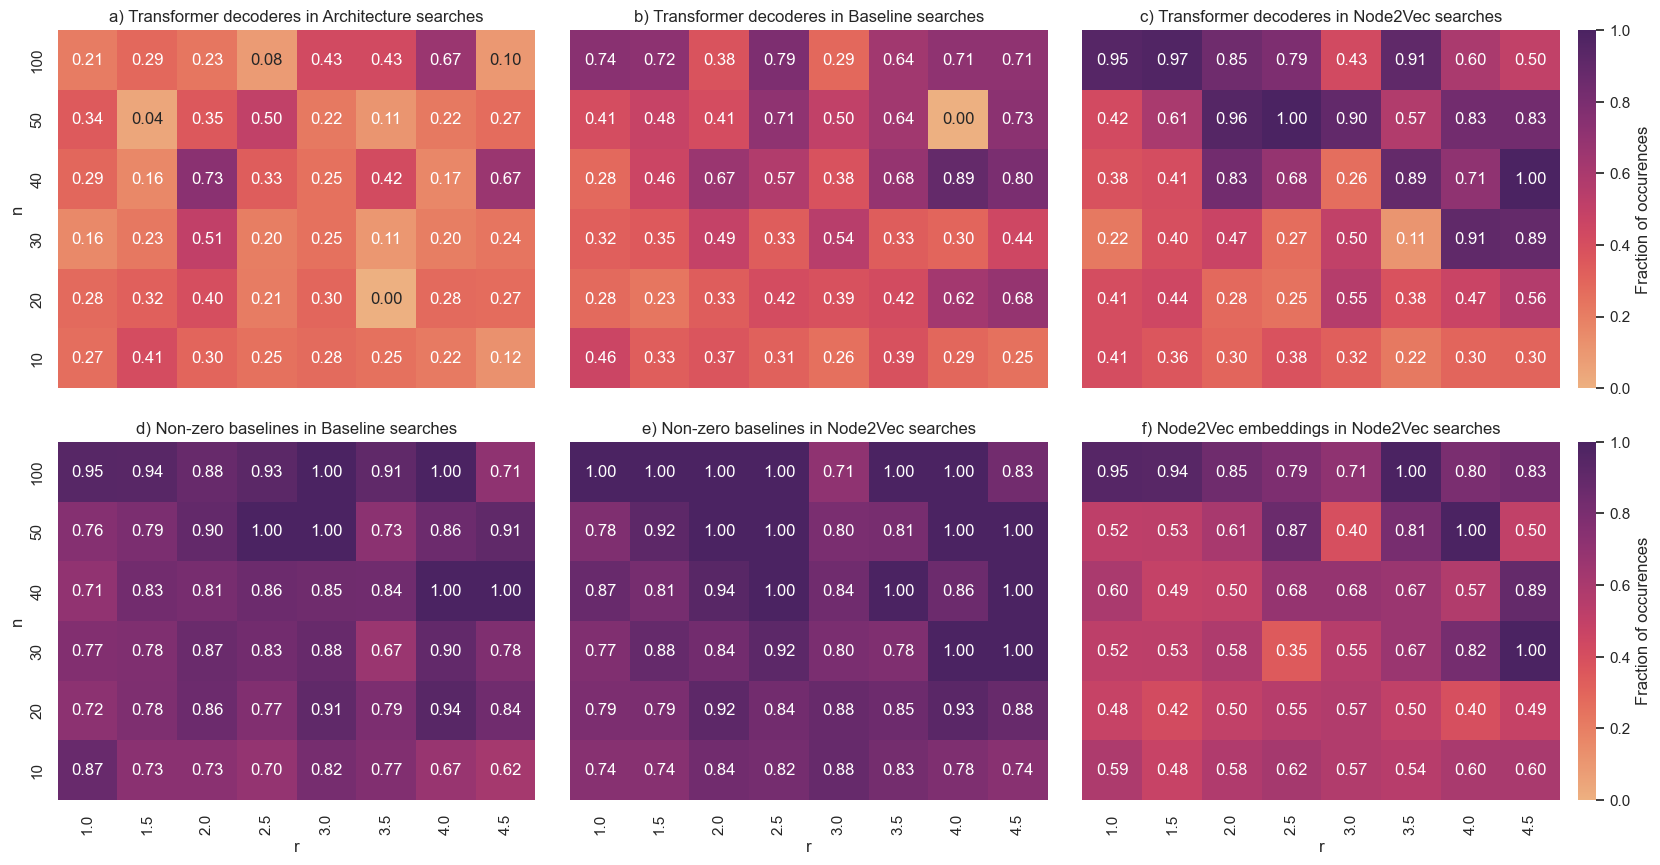

In [11]:
# Transformer Decoderes
# Generate dataframe with fraction of times each value of the feature of interest happens
csv_path = 'results/df_best_trials.csv'
feature = 'config/decoder'
df_best_trials = pd.read_csv(csv_path)
df_ft = best_trials2best_feaures(df_best_trials, feature)

# Drop some column to keep only Transformer
df_ft = df_ft.drop(columns=['GRU', 'LSTM'])

# Generate list of dataframes
list_df_t = []
for s in ['arch', 'baseline', 'node2vec']:
    # Get df for each search assumption
    # Keep only rows with specific s
    df_s = df_ft[df_ft['s'] == s]
    # Convert column r to row
    df_s = df_s.pivot(index='n', columns='r', values=['Transformer'])
    # Order from largest to smallest n
    df_s = df_s.reindex(index=df_s.index[::-1])
    list_df_t.append(df_s)


# Non-zero baselines 
# Generate dataframe with fraction of times each value of the feature of interest happens
csv_path = 'results/df_best_trials.csv'
feature = 'config/baseline'
df_best_trials = pd.read_csv(csv_path)
df_ft = best_trials2best_feaures(df_best_trials, feature)

# Keep only rows with baseline or node2vec search assumption
df_ft = df_ft[df_ft['s'] != 'arch']

# Sum ema, greedy, sample baselines
df_ft['baseline'] =  df_ft['ema'] + df_ft['greedy'] + df_ft['sample']

# Drop irrelevant columns
df_ft = df_ft.drop(columns=['zero', 'ema', 'greedy', 'sample'])

# Convert column r to row (for baseline search)
df_b = df_ft[df_ft['s'] == 'baseline'].pivot(index='n', columns='r', values=['baseline'])
# Order from largest to smallest n
df_b_b = df_b.reindex(index=df_b.index[::-1])

# Convert column r to row (for node2vec search)
df_n = df_ft[df_ft['s'] == 'node2vec'].pivot(index='n', columns='r', values=['baseline'])
# Order from largest to smallest n
df_b_n = df_n.reindex(index=df_n.index[::-1])


# Node2Vec embeddings
# Generate dataframe with fraction of times each value of the feature of interest happens
csv_path = 'results/df_best_trials.csv'
feature = 'config/dec_var_initializer'
df_best_trials = pd.read_csv(csv_path)
df_ft = best_trials2best_feaures(df_best_trials, feature)

# Keep only rows with s=node2vec
df_ft = df_ft[df_ft['s'] == 'node2vec']

# Drop irrelevant columns
df_ft = df_ft.drop(columns=['BasicVar'])

# Convert column r to row (for baseline search)
df_ft = df_ft.pivot(index='n', columns='r', values=['Node2VecVar'])
# Order from largest to smallest n
df_n_n = df_ft.reindex(index=df_ft.index[::-1])


# Generate plot
fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(21, 10))

# Subplot a) Transformer decoderes in architecture searches
inst = (0, 0)
sns.heatmap(list_df_t[0], annot=True, vmin=0, vmax=1, cmap='flare', cbar=True, fmt=".2f", square=True, ax=axes[inst],
            cbar_kws={'label': 'Fraction of occurences', 'pad': 0.03, "shrink": 1.0})
axes[inst].set_xticklabels([1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5])
axes[inst].set_xlabel('')
axes[inst].set_title('a) Transformer decoderes in Architecture searches')
axes[inst].collections[0].colorbar.ax.set_visible(False)
#axes[inst].text(0.0, 1.02, label_i, weight='bold', transform=axes[inst].transAxes)

# Subplot b) Transformer decoderes in baseline searches
inst = (0, 1)
sns.heatmap(list_df_t[1], annot=True, vmin=0, vmax=1, cmap='flare', cbar=True, fmt=".2f", square=True, ax=axes[inst],
            cbar_kws={'label': 'Fraction of occurences', 'pad': 0.03, "shrink": 1.0})
axes[inst].set_xticklabels([1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5])
axes[inst].set_xlabel('')
axes[inst].set_yticklabels([])
axes[inst].set_ylabel('')
axes[inst].set_title('b) Transformer decoderes in Baseline searches')
axes[inst].collections[0].colorbar.ax.set_visible(False)
#axes[inst].text(0.0, 1.02, label_i, weight='bold', transform=axes[inst].transAxes)

# Subplot c) Transformer decoderes in node2vec searches
inst = (0, 2)
label_i = 'c)'
sns.heatmap(list_df_t[2], annot=True, vmin=0, vmax=1, cmap='flare', cbar=True, fmt=".2f", square=True, ax=axes[inst],
            cbar_kws={'label': 'Fraction of occurences', 'pad': 0.03, "shrink": 1.0})
axes[inst].set_xticklabels([1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5])
axes[inst].set_xlabel('')
axes[inst].set_yticklabels([])
axes[inst].set_ylabel('')
axes[inst].set_title('c) Transformer decoderes in Node2Vec searches')
axes[inst].collections[0].colorbar.ax.set_visible(True)
#axes[inst].text(0.0, 1.02, label_i, weight='bold', transform=axes[inst].transAxes)


# Subplot d) Non-zero baseline in baseline searches
inst = (1, 0)
sns.heatmap(df_b_b, annot=True, vmin=0, vmax=1, cmap='flare', cbar=True, fmt=".2f", square=True, ax=axes[inst],
            cbar_kws={'label': 'Fraction of occurences', 'pad': 0.03, "shrink": 1.0})
axes[inst].set_xticklabels([1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5])
axes[inst].set_xlabel('r')
axes[inst].set_title('d) Non-zero baselines in Baseline searches')
axes[inst].collections[0].colorbar.ax.set_visible(False)

# Subplot e) Non-zero baseline in node2vec searches
inst = (1, 1)
sns.heatmap(df_b_n, annot=True, vmin=0, vmax=1, cmap='flare', cbar=True, fmt=".2f", square=True, ax=axes[inst],
            cbar_kws={'label': 'Fraction of occurences', 'pad': 0.03, "shrink": 1.0})
axes[inst].set_xticklabels([1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5])
axes[inst].set_xlabel('r')
axes[inst].set_yticklabels([])
axes[inst].set_ylabel('')
axes[inst].set_title('e) Non-zero baselines in Node2Vec searches')
axes[inst].collections[0].colorbar.ax.set_visible(False)


# Subplot f) Node2Vec embeddings in node2vec searches
inst = (1, 2)
sns.heatmap(df_n_n, annot=True, vmin=0, vmax=1, cmap='flare', cbar=True, fmt=".2f", square=True, ax=axes[inst],
            cbar_kws={'label': 'Fraction of occurences', 'pad': 0.03, "shrink": 1.0})
axes[inst].set_xticklabels([1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5])
axes[inst].set_xlabel('r')
axes[inst].set_ylabel('')
axes[inst].set_title('f) Node2Vec embeddings in Node2Vec searches')
axes[inst].collections[0].colorbar.ax.set_visible(True)


#plt.tight_layout()
plt.subplots_adjust(wspace=-0.15, hspace=0.15)
#plt.show()

plot_path = 'results/fraction_occurences.png'
plt.savefig(plot_path, dpi=300, bbox_inches='tight', pad_inches=0.1)

### The evolution of the probability that variables take the value of true

In [47]:
config = {
    # Encoder
    "node2vec": True,  # (bool).
    "n2v_dir": os.path.abspath("results/fig1/node2vec_emb"),  # (str).
    "n2v_dim": 128,  # (int).
    "n2v_pretrained": False,  # {False, True}
    "n2v_walk_len": 20,  # (int).
    "n2v_context_size": 10,  # (int).
    "n2v_walks_per_node": 10,  # (int).
    "n2v_p": 2.0,  # (int).
    "n2v_q": 0.25,  # (int).
    "n2v_batch_size": 8,  # (int).
    "n2v_lr": 0.07086871381806087,  # (float).
    "n2v_num_epochs": 30,  # (int).
    "n2v_workers": 0,  # (int). {0, 1, 2, 3, 4}
    "n2v_verbose": 1,  # (int). {0, 1, 2}

    # Initializers
    "dec_var_initializer": "Node2VecVar",  # (str). {"BasicVar", "Node2VecVar"}
    "dec_context_initializer": "Node2VecContext",  # (str). {"EmptyContext", "Node2VecContext"}

    # Embeddings
    "var_emb_size": 128,  # (int).
    "assignment_emb_size": 128,  # (int).
    "context_emb_size": 64,  # (int).
    "model_dim": 128,  # (int).

    # Architecture
    "decoder": 'Transformer',  # (str). {'GRU', 'LSTM', "Transformer"}
    "num_layers": 1,  # (int).
    "output_size": 1,  # (int). Decoder output size: {1, 2}
    "dropout": 0.1,  # (float).

    "hidden_size": 512,  # (int). Hidden size of the RNN.
    "trainable_state": False,  # (bool). Trainable initial state of the RNN if True, else zeros initial state.

    "num_heads": 1,  # (int). Number of heads of the Transformer decoder.
    "dense_size":128,  # (int). Number of units of the position-wise FFN in the Transformer decoder.

    # Training
    "num_samples": 5000,  # (int).
    "accumulation_episodes": 10,  # (int).
    "batch_size": 1,  #10 # (int).
    "vars_permutation": "fixed",  # (str). {"fixed", importance", "random", "batch"}
    "clip_grad": 1.5,  # (float > 0) e.g.:0.00015.
    "lr": 0.00002 ,  # (float). e.g.: 0.00015. or 0.00001

    # Baseline
    "baseline": 'ema',  # {'zero', 'greedy', 'sample'. 'ema'}
    "alpha_ema": 0.98,  # (float). 0 <= alpha <= 1. EMA decay.
    "k_samples": 32,  # (int). k >= 1. Number of samples used to obtain the sample baseline value.
    "sampling_temp": 1.5, # (float >= 1). Sampling temperature for sample baseline.

    # Exploration
    "logit_clipping": 0,  # (int >= 0)
    "logit_temp": 1,  # (float >= 1). Useful for improve exploration in evaluation.
    "entropy_estimator": 'crude',  # (str). {'crude', 'smooth'}
    "beta_entropy": 0.0,  # (float). beta >= 0.

    # Misc
    "sat_stopping": False,  # (bool). Stop when num_sat is equal with the num of clauses.
    "log_interval": 100,  # (int).
    "eval_interval": 1000,  # (int).
    "eval_strategies": [128],  # (int). 0 for greedy search, k >= 1 for k samples.
    "tensorboard_on": True,  # (bool).
    "extra_logging": True,  # (bool). Log Trainable state's weights.
    "raytune": False,  # (bool).
    "data_dir": os.path.abspath('data/rand/0020/0090/rand_n=0020_k=03_m=0090_i=01.cnf'),  # (str).
    "verbose": 1,  # {0, 1, 2}. If raytune is True, then verbose is set to 0.

    "log_dir": 'logs',  # (str).
    "output_dir": 'results/fig1/outputs',  # (str).
    "exp_name": 'exp_fig1',  # (str).
    "run_name": 'run',  # (str).
    "gpu": True,  # (bool).
    "checkpoint_dir": 'checkpoints'}  # None | str

pg_solver(config)



{'accumulation_episodes': 10,
 'alpha_ema': 0.98,
 'assignment_emb_size': 128,
 'baseline': 'ema',
 'batch_size': 1,
 'beta_entropy': 0.0,
 'checkpoint_dir': 'results/fig1/outputs/exp_fig1/run-20230912T010446/checkpoints',
 'clip_grad': 1.5,
 'context_emb_size': 64,
 'data_dir': '/Users/omargutierrez/Documents/Code/learning_sat_solvers/data/rand/0020/0090/rand_n=0020_k=03_m=0090_i=01.cnf',
 'dec_context_initializer': 'Node2VecContext',
 'dec_var_initializer': 'Node2VecVar',
 'decoder': 'Transformer',
 'dense_size': 128,
 'dropout': 0.1,
 'entropy_estimator': 'crude',
 'eval_interval': 1000,
 'eval_strategies': [128],
 'exp_name': 'exp_fig1',
 'extra_logging': True,
 'gpu': True,
 'log_dir': 'results/fig1/outputs/exp_fig1/run-20230912T010446/logs',
 'log_interval': 100,
 'logit_clipping': 0,
 'logit_temp': 1,
 'lr': 2e-05,
 'model_dim': 128,
 'n2v_batch_size': 8,
 'n2v_context_size': 10,
 'n2v_dim': 128,
 'n2v_dir': '/Users/omargutierrez/Documents/Code/learning_sat_solvers/results/fig

  2%|2         | 102/5000 [00:05<04:22, 18.66it/s]


Episode: 100, samples: 100/5000, num_sat: 78.0
	pg_loss: (78.0 - 78.34113048291587) * -13.748428344726562 + (0.0 * 13.748428344726562) = 4.69000800057084


  4%|4         | 202/5000 [00:11<04:22, 18.28it/s]


Episode: 200, samples: 200/5000, num_sat: 78.0
	pg_loss: (78.0 - 78.96852847164209) * -13.681721687316895 + (0.0 * 13.681721687316895) = 13.251136995249443


  6%|6         | 302/5000 [00:16<04:07, 18.96it/s]


Episode: 300, samples: 300/5000, num_sat: 79.0
	pg_loss: (79.0 - 78.77278199284298) * -13.833159446716309 + (0.0 * 13.833159446716309) = -3.1431429221681912


  8%|8         | 402/5000 [00:22<04:05, 18.73it/s]


Episode: 400, samples: 400/5000, num_sat: 81.0
	pg_loss: (81.0 - 78.9453914096064) * -13.179668426513672 + (0.0 * 13.179668426513672) = -27.079059967654278


 10%|#         | 502/5000 [00:27<04:12, 17.83it/s]


Episode: 500, samples: 500/5000, num_sat: 77.0
	pg_loss: (77.0 - 78.94183078196318) * -13.95427417755127 + (0.0 * 13.95427417755127) = 27.09683913792294


 12%|#2        | 602/5000 [00:32<03:57, 18.54it/s]


Episode: 600, samples: 600/5000, num_sat: 81.0
	pg_loss: (81.0 - 79.84218734683023) * -12.733915328979492 + (0.0 * 12.733915328979492) = -14.743488292284958


 14%|#4        | 702/5000 [00:38<03:51, 18.60it/s]


Episode: 700, samples: 700/5000, num_sat: 81.0
	pg_loss: (81.0 - 79.41776005908837) * -12.697221755981445 + (0.0 * 12.697221755981445) = -20.090051400926


 16%|#6        | 802/5000 [00:43<03:46, 18.52it/s]


Episode: 800, samples: 800/5000, num_sat: 76.0
	pg_loss: (76.0 - 79.80399502219035) * -12.40469741821289 + (0.0 * 12.40469741821289) = 47.18740723065932


 18%|#8        | 902/5000 [00:49<03:34, 19.12it/s]


Episode: 900, samples: 900/5000, num_sat: 77.0
	pg_loss: (77.0 - 80.44702854692142) * -11.956870079040527 + (0.0 * 11.956870079040527) = 41.215672494283226


 20%|#9        | 998/5000 [00:54<03:40, 18.17it/s]


Episode: 1000, samples: 1000/5000, num_sat: 77.0
	pg_loss: (77.0 - 80.53671280792513) * -11.590226173400879 + (0.0 * 11.590226173400879) = 40.99130135421593
-------------------------------------------------
Evaluation in episode: 1000. Num samples: 1000/5000. Num of sat clauses:


 20%|##        | 1002/5000 [00:55<06:10, 10.78it/s]

	Best of 128 samples: 86.0.
	Active search: 86.0.
-------------------------------------------------



 22%|##2       | 1102/5000 [01:00<03:34, 18.19it/s]


Episode: 1100, samples: 1100/5000, num_sat: 83.0
	pg_loss: (83.0 - 80.61163688023603) * -11.693530082702637 + (0.0 * 11.693530082702637) = -27.928395989377456


 24%|##4       | 1202/5000 [01:06<03:23, 18.62it/s]


Episode: 1200, samples: 1200/5000, num_sat: 81.0
	pg_loss: (81.0 - 80.34628509341914) * -10.201602935791016 + (0.0 * 10.201602935791016) = -6.668939910145642


 26%|##6       | 1302/5000 [01:11<03:16, 18.86it/s]


Episode: 1300, samples: 1300/5000, num_sat: 76.0
	pg_loss: (76.0 - 80.88940336848665) * -11.760529518127441 + (0.0 * 11.760529518127441) = 57.50197264111904


 28%|##8       | 1402/5000 [01:17<03:08, 19.12it/s]


Episode: 1400, samples: 1400/5000, num_sat: 80.0
	pg_loss: (80.0 - 80.72778224236615) * -14.978477478027344 + (0.0 * 14.978477478027344) = 10.901069926189559


 30%|###       | 1502/5000 [01:22<03:05, 18.85it/s]


Episode: 1500, samples: 1500/5000, num_sat: 83.0
	pg_loss: (83.0 - 80.70684569757867) * -12.04909610748291 + (0.0 * 12.04909610748291) = -27.630436579162517


 32%|###2      | 1602/5000 [01:27<02:59, 18.93it/s]


Episode: 1600, samples: 1600/5000, num_sat: 79.0
	pg_loss: (79.0 - 81.11033822947651) * -12.191394805908203 + (0.0 * 12.191394805908203) = 25.72796652954945


 34%|###4      | 1702/5000 [01:33<02:54, 18.93it/s]


Episode: 1700, samples: 1700/5000, num_sat: 80.0
	pg_loss: (80.0 - 80.37411358481006) * -12.51722240447998 + (0.0 * 12.51722240447998) = 4.682862945604819


 36%|###6      | 1802/5000 [01:38<02:47, 19.07it/s]


Episode: 1800, samples: 1800/5000, num_sat: 80.0
	pg_loss: (80.0 - 81.36703753560042) * -14.298978805541992 + (0.0 * 14.298978805541992) = 19.547240747930722


 38%|###8      | 1902/5000 [01:44<02:45, 18.71it/s]


Episode: 1900, samples: 1900/5000, num_sat: 78.0
	pg_loss: (78.0 - 81.21544671562384) * -9.690422058105469 + (0.0 * 9.690422058105469) = 31.159035779744052


 40%|###9      | 1998/5000 [01:49<02:56, 17.02it/s]


Episode: 2000, samples: 2000/5000, num_sat: 83.0
	pg_loss: (83.0 - 81.25860911159454) * -12.621898651123047 + (0.0 * 12.621898651123047) = -21.979659305442866
-------------------------------------------------
Evaluation in episode: 2000. Num samples: 2000/5000. Num of sat clauses:


 40%|####      | 2002/5000 [01:50<04:30, 11.09it/s]

	Best of 128 samples: 87.0.
	Active search: 87.0.
-------------------------------------------------



 42%|####2     | 2102/5000 [01:55<03:19, 14.50it/s]


Episode: 2100, samples: 2100/5000, num_sat: 85.0
	pg_loss: (85.0 - 81.88839972197361) * -10.92119026184082 + (0.0 * 10.92119026184082) = -33.982378655122965


 44%|####4     | 2202/5000 [02:01<02:35, 18.02it/s]


Episode: 2200, samples: 2200/5000, num_sat: 82.0
	pg_loss: (82.0 - 82.06079102253574) * -11.298188209533691 + (0.0 * 11.298188209533691) = 0.6868284140587794


 46%|####6     | 2302/5000 [02:06<02:25, 18.53it/s]


Episode: 2300, samples: 2300/5000, num_sat: 84.0
	pg_loss: (84.0 - 82.26187625954901) * -11.748319625854492 + (0.0 * 11.748319625854492) = -20.420033252103956


 48%|####8     | 2402/5000 [02:12<02:18, 18.81it/s]


Episode: 2400, samples: 2400/5000, num_sat: 84.0
	pg_loss: (84.0 - 82.02254562428186) * -7.953856945037842 + (0.0 * 7.953856945037842) = -15.72838921980119


 50%|#####     | 2503/5000 [02:18<02:13, 18.75it/s]


Episode: 2500, samples: 2500/5000, num_sat: 83.0
	pg_loss: (83.0 - 82.28111518872267) * -8.025530815124512 + (0.0 * 8.025530815124512) = -5.769432205431215


 52%|#####2    | 2603/5000 [02:23<02:07, 18.76it/s]


Episode: 2600, samples: 2600/5000, num_sat: 77.0
	pg_loss: (77.0 - 82.1475588188979) * -11.814927101135254 + (0.0 * 11.814927101135254) = 60.81803219408465


 54%|#####4    | 2703/5000 [02:29<02:01, 18.89it/s]


Episode: 2700, samples: 2700/5000, num_sat: 80.0
	pg_loss: (80.0 - 82.25122540900554) * -12.714264869689941 + (0.0 * 12.714264869689941) = 28.622676131472534


 56%|#####6    | 2803/5000 [02:34<02:09, 16.98it/s]


Episode: 2800, samples: 2800/5000, num_sat: 80.0
	pg_loss: (80.0 - 82.26171141758005) * -15.10536003112793 + (0.0 * 15.10536003112793) = 34.16396524905931


 58%|#####8    | 2903/5000 [02:39<01:50, 19.03it/s]


Episode: 2900, samples: 2900/5000, num_sat: 85.0
	pg_loss: (85.0 - 83.1364656526383) * -14.015793800354004 + (0.0 * 14.015793800354004) = -26.11891315249896


 60%|#####9    | 2999/5000 [02:45<01:44, 19.17it/s]


Episode: 3000, samples: 3000/5000, num_sat: 84.0
	pg_loss: (84.0 - 83.29962406914773) * -9.532877922058105 + (0.0 * 9.532877922058105) = -6.676598248362542
-------------------------------------------------
Evaluation in episode: 3000. Num samples: 3000/5000. Num of sat clauses:


 60%|######    | 3003/5000 [02:45<02:47, 11.91it/s]

	Best of 128 samples: 88.0.
	Active search: 88.0.
-------------------------------------------------



 62%|######2   | 3103/5000 [02:51<01:40, 18.83it/s]


Episode: 3100, samples: 3100/5000, num_sat: 84.0
	pg_loss: (84.0 - 82.45367868781591) * -9.03654956817627 + (0.0 * 9.03654956817627) = -13.973409185878909


 64%|######4   | 3203/5000 [02:56<01:34, 19.06it/s]


Episode: 3200, samples: 3200/5000, num_sat: 85.0
	pg_loss: (85.0 - 83.2371285515564) * -9.816205978393555 + (0.0 * 9.816205978393555) = -17.304709251351415


 66%|######6   | 3303/5000 [03:02<01:29, 18.86it/s]


Episode: 3300, samples: 3300/5000, num_sat: 84.0
	pg_loss: (84.0 - 83.44722595062709) * -12.118637084960938 + (0.0 * 12.118637084960938) = -6.698868094334625


 68%|######8   | 3403/5000 [03:07<01:25, 18.78it/s]


Episode: 3400, samples: 3400/5000, num_sat: 84.0
	pg_loss: (84.0 - 83.43898615197428) * -10.582063674926758 + (0.0 * 10.582063674926758) = -5.9366842623238885


 70%|#######   | 3503/5000 [03:13<01:44, 14.33it/s]


Episode: 3500, samples: 3500/5000, num_sat: 84.0
	pg_loss: (84.0 - 84.0304491398872) * -10.577264785766602 + (0.0 * 10.577264785766602) = 0.32206861508571943


 72%|#######2  | 3603/5000 [03:19<01:14, 18.67it/s]


Episode: 3600, samples: 3600/5000, num_sat: 87.0
	pg_loss: (87.0 - 83.82069187781622) * -8.55178451538086 + (0.0 * 8.55178451538086) = -27.18875796891588


 74%|#######4  | 3703/5000 [03:24<01:09, 18.67it/s]


Episode: 3700, samples: 3700/5000, num_sat: 85.0
	pg_loss: (85.0 - 84.16867856653448) * -9.863913536071777 + (0.0 * 9.863913536071777) = -8.200082740387122


 76%|#######6  | 3803/5000 [03:29<01:03, 18.89it/s]


Episode: 3800, samples: 3800/5000, num_sat: 84.0
	pg_loss: (84.0 - 84.21002458559497) * -7.619802951812744 + (0.0 * 7.619802951812744) = 1.600345957269764


 78%|#######8  | 3903/5000 [03:35<01:00, 18.06it/s]


Episode: 3900, samples: 3900/5000, num_sat: 87.0
	pg_loss: (87.0 - 84.75498075232937) * -5.153174877166748 + (0.0 * 5.153174877166748) = -11.568976785852065


 80%|#######9  | 3999/5000 [03:40<00:52, 19.13it/s]


Episode: 4000, samples: 4000/5000, num_sat: 86.0
	pg_loss: (86.0 - 84.75497391781491) * -8.680670738220215 + (0.0 * 8.680670738220215) = -10.807661479945082
-------------------------------------------------
Evaluation in episode: 4000. Num samples: 4000/5000. Num of sat clauses:


 80%|########  | 4001/5000 [03:41<01:55,  8.62it/s]

	Best of 128 samples: 89.0.
	Active search: 89.0.
-------------------------------------------------



 82%|########2 | 4101/5000 [03:46<00:49, 18.29it/s]


Episode: 4100, samples: 4100/5000, num_sat: 85.0
	pg_loss: (85.0 - 84.74456650636266) * -6.016225337982178 + (0.0 * 6.016225337982178) = -1.5367454565902792


 84%|########4 | 4203/5000 [03:52<00:42, 18.72it/s]


Episode: 4200, samples: 4200/5000, num_sat: 85.0
	pg_loss: (85.0 - 85.57838833811714) * -5.737847805023193 + (0.0 * 5.737847805023193) = 3.318704256316424


 86%|########6 | 4303/5000 [03:57<00:38, 18.31it/s]


Episode: 4300, samples: 4300/5000, num_sat: 87.0
	pg_loss: (87.0 - 85.37363046500825) * -7.092453479766846 + (0.0 * 7.092453479766846) = -11.534950267839042


 88%|########8 | 4403/5000 [04:03<00:32, 18.57it/s]


Episode: 4400, samples: 4400/5000, num_sat: 87.0
	pg_loss: (87.0 - 85.47911947443714) * -4.577459812164307 + (0.0 * 4.577459812164307) = -6.961769484867316


 90%|######### | 4503/5000 [04:08<00:27, 18.28it/s]


Episode: 4500, samples: 4500/5000, num_sat: 84.0
	pg_loss: (84.0 - 86.10505701796333) * -5.935906887054443 + (0.0 * 5.935906887054443) = 12.495422450570835


 92%|#########2| 4603/5000 [04:14<00:21, 18.89it/s]


Episode: 4600, samples: 4600/5000, num_sat: 89.0
	pg_loss: (89.0 - 86.08170843895857) * -2.9381041526794434 + (0.0 * 2.9381041526794434) = -8.574244554225196


 94%|#########4| 4701/5000 [04:19<00:15, 18.96it/s]


Episode: 4700, samples: 4700/5000, num_sat: 86.0
	pg_loss: (86.0 - 86.49055113740283) * -6.71437406539917 + (0.0 * 6.71437406539917) = 3.293743834729641


 96%|#########6| 4803/5000 [04:25<00:10, 18.41it/s]


Episode: 4800, samples: 4800/5000, num_sat: 87.0
	pg_loss: (87.0 - 86.90129856823724) * -3.407975673675537 + (0.0 * 3.407975673675537) = -0.3363720784044409


 98%|#########8| 4903/5000 [04:31<00:05, 18.35it/s]


Episode: 4900, samples: 4900/5000, num_sat: 88.0
	pg_loss: (88.0 - 87.06034247589254) * -2.137965679168701 + (0.0 * 2.137965679168701) = -2.008955536714386


100%|#########9| 4999/5000 [04:36<00:00, 18.89it/s]


Episode: 5000, samples: 5000/5000, num_sat: 88.0
	pg_loss: (88.0 - 87.47336225226323) * -4.530998229980469 + (0.0 * 4.530998229980469) = -2.3861947028362107
-------------------------------------------------
Evaluation in episode: 5000. Num samples: 5000/5000. Num of sat clauses:


100%|#########9| 4999/5000 [04:36<00:00, 18.06it/s]

	Best of 128 samples: 89.0.
	Active search: 89.0.
-------------------------------------------------

-------------------------------------------------
Optimization process finished at episode: 5000.
Number of samples: 5000.
Number or trainable parameters: 190913.
Stop creiteria: Maximum number of episodes reached.
Active search results:
	Num_sat: 89.0
	Samples: 4000
	Episode: 4000
	Strategy: sampled-128-1
	Sol:
[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0]
-------------------------------------------------



In [2]:
log_dir = 'results/fig1/outputs/exp_fig1/run-20230912T010446/logs'

# Read tensorboard logs with tbparser
reader = SummaryReader(log_dir, pivot=False)  # extra_columns={'dir_name'}
df = reader.tensors

# Keep only rows with tag that contains 'buffer/action_probs'
df = df[df['tag'].str.contains('buffer/action_probs')]

# Get stats
min_step = df['step'].min()
max_step = df['step'].max()
num_episodes = df['step'].nunique()
num_variables = df[df['step'] == min_step].shape[0]

#print(min_step, max_step, num_episodes, num_variables)

df.rename(columns = {'step': 'Iteration', 'tag': 'Var'}, inplace = True)

# Get the numbers in the tag
df['Var'] = df['Var'].str.extract('(\d+)', expand=False).astype(int)

# Reshape dataframe
table = pd.pivot_table(df, index='Var', columns='Iteration', values='value')

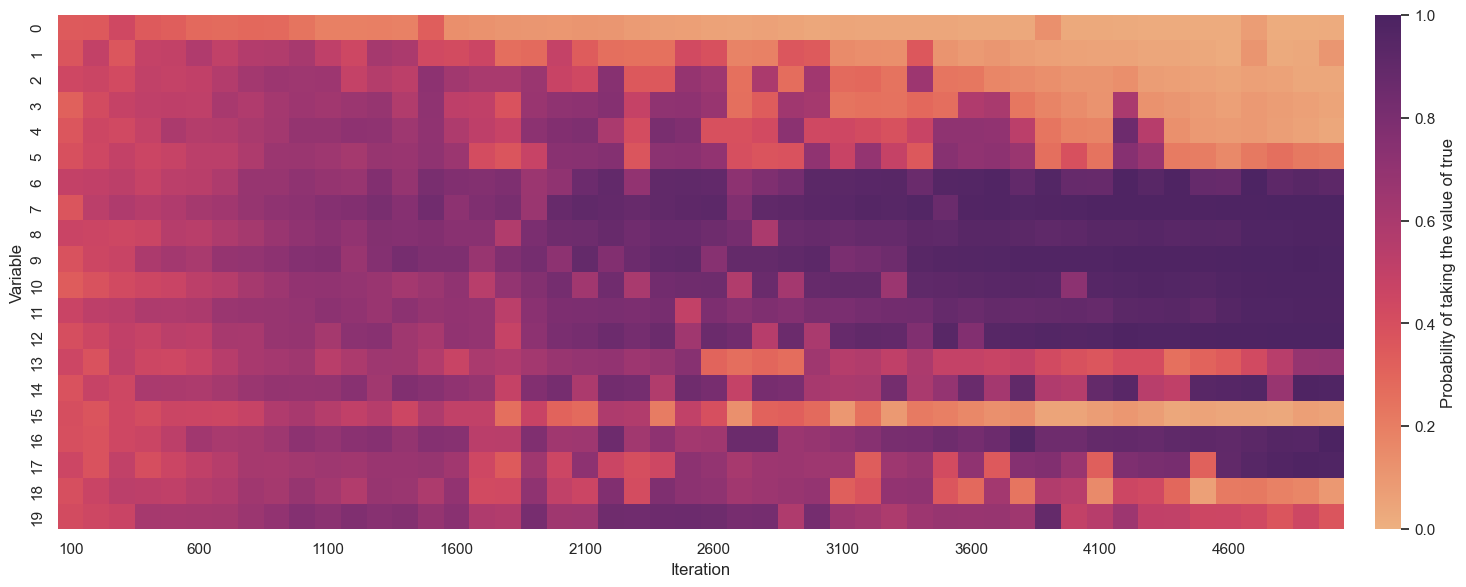

In [3]:
plt.figure(figsize = (20,8))
sns.set_theme(style="whitegrid")
ax = sns.heatmap(table, vmin=0, vmax=1, square=True,  xticklabels=5, linewidths=0.0, cmap='flare',
                 cbar=True, cbar_kws={'label': 'Probability of taking the value of true', "shrink": .835, 'pad':0.02})
ax.set_ylabel('Variable')

#plt.tight_layout()
plot_path = 'results/assignment_prob.png'
plt.savefig(plot_path, dpi=300, bbox_inches='tight', pad_inches=0.1)
#plt.show()